# HDF5 in Python

In [6]:
%matplotlib inline

In [12]:
import os
import time
import numpy as np
import pandas as pd
import h5py
import tables as tb
import matplotlib.pyplot as plt

In [10]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/hdf5-pydata-munich/data


# Data

In [2]:
arr = np.random.normal(loc=0, scale=1, size=200)
matrix = np.random.random((100, 50))

# h5py

The h5py library is very close to the HDF5 C API. It's a low-level wrapper.

### Write

In [15]:
hdf = h5py.File('h5py-file.h5', 'w')
hdf.create_dataset(name='MyDataset', shape=matrix.shape, dtype=matrix.dtype, data=matrix)
hdf.close()

### More pythonic approaches

In [16]:
with h5py.File('h5py-context-manager0.h5', 'w') as hdf:
    hdf.create_dataset('MyDataset', matrix.shape, matrix.dtype, matrix)

In [17]:
with h5py.File('h5py-context-manager1.h5', 'w') as hdf:
    # create the datasets first
    ds0 = hdf.create_dataset('Dataset0', matrix.shape, matrix.dtype)
    ds1 = hdf.create_dataset('Dataset1', matrix.shape, matrix.dtype)
    # fill them up later. There are 2 syntaxes.
    ds0[:] = matrix
    ds1[...] = matrix

### Pick the correct HDF5 datatype

In [19]:
with h5py.File('h5py-different-datatypes.h5', 'w') as hdf:
    hdf.create_dataset('numpy_dtype', arr.shape, arr.dtype, arr)
    hdf.create_dataset('IEEE_F64_Big_Endian', arr.shape, h5py.h5t.IEEE_F64BE, arr)
    # if we store floats as unsigned integers (8 bit) we end up with invalid data
    hdf.create_dataset('Unsigned_8Bit_Big_Endian', arr.shape, h5py.h5t.STD_U8BE, arr)

### Groups, Datasets, Attributes

In [24]:
with h5py.File('h5py-groups-datasets-attributes.h5', 'w') as hdf:
    ds0 = hdf.create_dataset('MyDatasetInRoot', arr.shape, arr.dtype)
    ds0[:] = arr
    ds0.attrs['Unit'] = 'm/s'
    # attributes can be numpy array too!
    attr_data = np.zeros((2,), dtype='int32')
    attr_data[0] = 100
    attr_data[1] = 200
    ds0.attrs.create(name='Speed', data=attr_data)
    
    # create a group by using an absolute path.
    # Missing groups along the path will be created automatically.
    path_to_group = '/SomeMissingGroup/MyGroup'
    gr0 = hdf.create_group(path_to_group)
    
    # create a group by using a relative path
    gr1 = gr0.create_group('MyOtherGroup')
    
    # access a group with an absolute path
    my_group = hdf['/SomeMissingGroup/MyGroup']
    
    # access a group with a relative path
    root_group = my_group.parent.parent

    # set some attributes to the groups
    gr0.attrs['Experiment ID'] = 123
    gr1.attrs['Experiment ID'] = 456
    
    # create a dataset inside a group
    ds_in_group = gr1.create_dataset('MyOtherDataset', matrix.shape, matrix.dtype)
    # if you have a reference to the dataset, you can set the data with this syntax: 
    # ds_in_group[:] = matrix
    # otherwise you have to know the absolute path to your dataset
    path_to_dataset = '/SomeMissingGroup/MyGroup/MyOtherGroup/MyOtherDataset'
    hdf[path_to_dataset][:] = matrix
    
    # set some attributes to this other dataset
    ds_in_group.attrs['Unit'] = '°C'
    ds_in_group.attrs['Recorded on'] = '25th November 2017'
    
    print(root_group)

<HDF5 group "/" (2 members)>


### View the HDF5 file

Open the `.h5` file with [HDF View](https://support.hdfgroup.org/products/java/hdfview/), [HDF Compass](https://support.hdfgroup.org/projects/compass/) or [ViTables](http://vitables.org/). I use HDF View.

### Plot

<HDF5 dataset "MyDatasetInRoot": shape (200,), type "<f8">
['Unit', 'Speed']
['m/s', array([100, 200], dtype=int32)]
[('Unit', 'm/s'), ('Speed', array([100, 200], dtype=int32))]


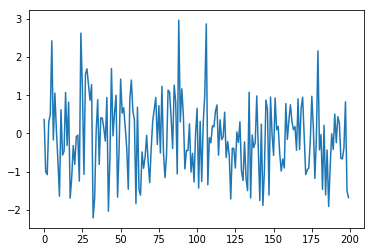

In [32]:
with h5py.File('h5py-groups-datasets-attributes.h5', 'r') as hdf:
    ds = hdf['MyDatasetInRoot']
    print(ds)
    print(list(ds.attrs.keys()))
    print(list(ds.attrs.values()))
    print(list(ds.attrs.items()))
    plt.plot(ds[:])
    # plt.plot(ds[...])

# PyTables

PyTables provides a higher abstraction over HDF5. This doesn't make it slower than h5py though.

At the moment PyTables does NOT depend on h5py.

Pandas uses PyTables when reading/writing HDF5 files.

### Write

In PyTables the HDF5 Dataset object is implemented by four higher level abstractions:

- **Array**: homogeneous dataset
- **CArray**: homogeneous dataset, chunked storage
- **EArray**: homogeneous dataset, extendable (append)
- **Table**: compound dataset, extendable (append)

Well, there is also the **Unimplemented** class, to indicate an HDF5 dataset not supported by PyTables.

In [33]:
with tb.open_file('pytables-file.h5', 'w') as hdf:
    hdf.create_array(where='/', name='Array0', obj=data)
    hdf.create_array(where=hdf.root, name='Array1', obj=data, title='My Title')

### Read

PyTables has a feature called "Natural Naming": nodes can be accessed with the dot notation.

In [34]:
with tb.open_file('pytables-file.h5', 'r') as hdf:
    # the array is just a proxy object
    print(hdf.root.Array0)
    # the actual data can be accessed with these 2 syntaxes
    print(hdf.root.Array0[:])
    # print(hdf.root.Array0[...])

/Array0 (Array(100, 50)) ''
[[ 0.71380494  0.44584969  0.6794647  ...,  0.89219519  0.71395159
   0.78997027]
 [ 0.51435576  0.72341283  0.45315476 ...,  0.39504408  0.36547297
   0.44215131]
 [ 0.00407737  0.2784139   0.81908976 ...,  0.74263128  0.2164956
   0.93955435]
 ..., 
 [ 0.77200192  0.9773762   0.16806772 ...,  0.88629928  0.85947854
   0.60734443]
 [ 0.38418314  0.45741326  0.57958015 ...,  0.10333209  0.00428363
   0.41583694]
 [ 0.38663118  0.15884985  0.11684016 ...,  0.75791181  0.85694484
   0.53966956]]


### In-memory Read/Write

See also the PyTables documentation on [in-memory HDF5 files](http://www.pytables.org/cookbook/inmemory_hdf5_files.html).

In [35]:
# open file in-memory, save to disk
with tb.open_file('pytables-in-memory.h5', 'w', driver='H5FD_CORE') as hdf:
    hdf.create_array(where='/', name='Array', obj=data)

In [36]:
# open file in-memory, DO NOT save to disk
with tb.open_file('pytables-in-memory.h5', 'w', driver='H5FD_CORE', 
                  driver_core_backing_store=0) as hdf:
    hdf.create_array(where='/', name='Array', obj=data)

In [37]:
with tb.open_file('pytables-in-memory.h5', 'r', driver='H5FD_CORE') as hdf:
    print(hdf.root.Array[...])

[[ 0.71380494  0.44584969  0.6794647  ...,  0.89219519  0.71395159
   0.78997027]
 [ 0.51435576  0.72341283  0.45315476 ...,  0.39504408  0.36547297
   0.44215131]
 [ 0.00407737  0.2784139   0.81908976 ...,  0.74263128  0.2164956
   0.93955435]
 ..., 
 [ 0.77200192  0.9773762   0.16806772 ...,  0.88629928  0.85947854
   0.60734443]
 [ 0.38418314  0.45741326  0.57958015 ...,  0.10333209  0.00428363
   0.41583694]
 [ 0.38663118  0.15884985  0.11684016 ...,  0.75791181  0.85694484
   0.53966956]]


### TODO: learn how to use ptdump (and h5dump)

In [39]:
FILENAME = 'pytables-file.h5'
!ptdump {FILENAME}

/ (RootGroup) ''
/Array0 (Array(100, 50)) ''
/Array1 (Array(100, 50)) 'My Title'


### Attributes

In [40]:
with tb.open_file('pytables-attributes.h5', 'w') as hdf:
    hdf.create_array(where=hdf.root, name='Array', obj=data, title='My Title')
    hdf.set_node_attr(where='/Array', attrname='SomeAttribute', attrvalue='SomeValue')
    hdf.create_group('/', 'Group')
    hdf.set_node_attr('/Group', attrname='MyAttribute', attrvalue='MyValue')

### Array


In [39]:
# TODO

### CArray

In [ ]:
# TODO

### EArray

In [ ]:
# TODO

### Tables

In order to emulate in Python records mapped to HDF5 C structs PyTables implements a special class so as to easily define all its fields and other properties.

In [41]:
class Particle(tb.IsDescription):
    identity = tb.StringCol(itemsize=22, dflt=" ", pos=0)  # character String
    idnumber = tb.Int16Col(dflt=1, pos=1)  # short integer
    speed = tb.Float32Col(dflt=1, pos=2)  # single-precision
    
with tb.open_file('pytables-tables.h5', 'w') as hdf:
    table =hdf.create_table(where='/', name='MyTable', description=Particle)
    num_records = 100
    # Get the record object associated with the table:
    row = table.row
    for i in range(num_records):
        row['identity'] = 'This is particle: {}'.format(i)
        row['idnumber'] = i
        row['speed'] = i * 2.0
        # inject the Record values into the table
        row.append()
    # Flush the table buffers
    table.flush()
    
    # We can set some attributes for the table
    hdf.set_node_attr('/MyTable', attrname='MyAttribute', attrvalue='MyValue')
    hdf.set_node_attr('/MyTable', attrname='CreatedOn', attrvalue='2017-11-25')

A description can be nested inside another description (this will look weird...)

In [42]:
class Particle(tb.IsDescription):
    # 16-character String
    name = tb.StringCol(16)
    # signed 64-bit integer
    idnumber = tb.Int64Col()
    # unsigned short integer
    ADCcount = tb.UInt16Col()
    # unsigned byte
    TDCcount = tb.UInt8Col()
    # integer
    grid_i = tb.Int32Col()
    # integer
    grid_j = tb.Int32Col()

    # A sub-structure (nested data-type)
    class Properties(tb.IsDescription):
        # 2-D float array (single-precision)
        pressure = tb.Float32Col(shape=(2, 3))
        # 3-D float array (double-precision)
        energy = tb.Float64Col(shape=(2, 3, 4))
        
        
with tb.open_file('pytables-tables-nested.h5', 'w') as hdf:
    table = hdf.create_table(where='/', name='MyTable', description=Particle)
    num_records = 100
    row = table.row
    for i in range(num_records):
        # First, assign the values to the Particle record
        row['name'] = np.random.choice(['Superman', 'Spider-Man', 'Batman'])
        row['idnumber'] = np.random.randint(0, 100, dtype='int64')
        row['ADCcount'] = i * 2.0
        row['TDCcount'] = np.random.randint(0, 255, dtype='uint8')
        row['grid_i'] = np.random.randint(0, 100, dtype='int32')
        row['grid_j'] = np.random.randint(0, 100, dtype='int32')

        # Fill the nested data-type Properties
        row['Properties/pressure'] = np.random.random((2, 3))
        row['Properties/energy'] = np.random.random((2, 3, 4))

        row.append()

    table.flush()

### Create HDF5 file from CSV

### Create HDF5 file from Parquet

### Becnhmark with where, read_where, other syntaxes...

### Big Data!

Load an HDF5 file bigger than 10 GB (the RAM on my machine). 15-20 GB should be enough.

In [22]:
big_file_path = os.path.join(data_dir, 'big_file.h5')

t0 = time.time()
# create a big array from a normal distribution
gaussian_arr = np.random.normal(loc=0, scale=1, size=1000000)
# create a big array from a uniform distribution
uniform_arr = np.random.uniform(low=6, high=7, size=1000000)
t1 = time.time()
print('Creating the data took {:.2f}s'.format(t1 - t0))

t_start = time.time()
with h5py.File(big_file_path, 'w') as hdf:
    num_datasets = 200  # 200 dataset -> a bit more than 3GB

    gr_gaussian = hdf.create_group('GaussianGroup')
    for i in range(num_datasets):
        dataset_name = 'GaussianDataset_{0:03}'.format(i)
        gr_gaussian.create_dataset(dataset_name, dtype=gaussian_arr.dtype, data=gaussian_arr)

    gr_uniform = hdf.create_group('UniformGroup')
    for i in range(num_datasets):
        dataset_name = 'UniformDataset_{0:03}'.format(i)
        gr_uniform.create_dataset(dataset_name, dtype=uniform_arr.dtype, data=uniform_arr)

t_stop = time.time()
print('Creating the HDF5 file took {:.2f}s'.format(t_stop - t_start))

Creating the data took 0.09s
Creating the HDF5 file took 32.49s


In [23]:
!ptdump {big_file_path}

/ (RootGroup) ''
/GaussianGroup (Group) ''
/GaussianGroup/GaussianDataset_000 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_001 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_002 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_003 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_004 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_005 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_006 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_007 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_008 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_009 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_010 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_011 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_012 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_013 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_014 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_015 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_016 (Array(1000000,)) ''
/Gaus

/UniformGroup (Group) ''
/UniformGroup/UniformDataset_000 (Array(1000000,)) ''
/UniformGroup/UniformDataset_001 (Array(1000000,)) ''
/UniformGroup/UniformDataset_002 (Array(1000000,)) ''
/UniformGroup/UniformDataset_003 (Array(1000000,)) ''
/UniformGroup/UniformDataset_004 (Array(1000000,)) ''
/UniformGroup/UniformDataset_005 (Array(1000000,)) ''
/UniformGroup/UniformDataset_006 (Array(1000000,)) ''
/UniformGroup/UniformDataset_007 (Array(1000000,)) ''
/UniformGroup/UniformDataset_008 (Array(1000000,)) ''
/UniformGroup/UniformDataset_009 (Array(1000000,)) ''
/UniformGroup/UniformDataset_010 (Array(1000000,)) ''
/UniformGroup/UniformDataset_011 (Array(1000000,)) ''
/UniformGroup/UniformDataset_012 (Array(1000000,)) ''
/UniformGroup/UniformDataset_013 (Array(1000000,)) ''
/UniformGroup/UniformDataset_014 (Array(1000000,)) ''
/UniformGroup/UniformDataset_015 (Array(1000000,)) ''
/UniformGroup/UniformDataset_016 (Array(1000000,)) ''
/UniformGroup/UniformDataset_017 (Array(1000000,)) ''
/Un

Instead of `ptdump` we can walk the groups from the root node.

In [25]:
with tb.open_file(big_file_path, 'r') as hdf:
    for group in hdf.walk_groups('/'):
        for array in hdf.list_nodes(group, classname='Array'):
            print(array)

/GaussianGroup/GaussianDataset_000 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_001 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_002 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_003 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_004 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_005 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_006 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_007 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_008 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_009 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_010 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_011 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_012 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_013 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_014 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_015 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_016 (Array(1000000,)) ''
/GaussianGroup/GaussianDataset_017 (Array(100000

### Read that big data!

In [24]:
with tb.open_file(big_file_path, 'r') as hdf:
    # the array is just a proxy object
    print(hdf.root.GaussianGroup.GaussianDataset_004)

/GaussianGroup/GaussianDataset_004 (Array(1000000,)) ''


### Benchmark with/without numepr

### Becnhmark with where, read_where, other syntaxes...

### Critics to HDF5 and other formats

Brief info on zarr, feather and others...

### Reference

- [Introduction to HDF5](https://www.youtube.com/watch?v=BAjsCldRMMc) by Quincey Koziol
- [HDF5 is Eating the World](https://www.youtube.com/watch?v=nddj5OA8LJo) by Andrew Collette
- [HDF5 take 2 - h5py & PyTables](https://www.youtube.com/watch?v=ofLFhQ9yxCw) by Tom Kooij